### Introduction

We have taken the Woodbine Horse Racing Results database from Kaggle (https://www.kaggle.com/noqcks/woodbine-races/version/1) and will
be attempting to determine which horse will win a race based on it's characteristics.  

Our process will be to use a sequential NN to classify the winner of a race, then compare the model's accuracy to traditional
machine learning models.


In [113]:
#Imported libraries
import pandas as pd
import numpy as np
import glob
import os
import re
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing, model_selection
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn import svm, datasets
from sklearn.model_selection import cross_val_score

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

### Data Exploration

In [151]:
#Our dataset is only 4k records, with 27 columns
df = pd.read_csv('woodbine_horses.csv')
df.shape

(4370, 27)

In [153]:
print(df.columns)

Index(['track', 'card_id', 'race_date', 'breed', 'name', 'weight', 'age',
       'sex', 'meds_and_equip', 'jockey', 'dollar_odds', 'program_number',
       'post_position', 'claim_price', 'start_position', 'finish_position',
       'finish_time', 'speed_rating', 'trainer', 'owner', 'win_payoff',
       'place_payoff', 'show_payoff', 'weather', 'distance', 'race_type',
       'track_conditions'],
      dtype='object')


In [154]:
#First look at the data
df.head()

,track,card_id,race_date,breed,name,weight,age,sex,meds_and_equip,jockey,...,speed_rating,trainer,owner,win_payoff,place_payoff,show_payoff,weather,distance,race_type,track_conditions
0,WO,D,2015-06-20 00:00:00,TB,Madam Premier,119,4,M,Lb,S Ryan,...,44.0,O'Keefe Thomas,Emily Anne Walker,0.0,0.0,0.0,Cloudy,900.0,Claiming,FT
1,WO,D,2015-07-19 00:00:00,TB,Notion Sonet,118,3,C,L,L Contreras,...,96.0,Carroll Josie,Ivan Dalos,0.0,0.0,0.0,Cloudy,650.0,Allowance,FT
2,WO,D,2015-07-25 00:00:00,TB,Big Red Bugsy,121,5,G,L,S R Bahen,...,83.0,Fournier Mark,"Carruthers, Carruthers, Carruthers, Carruthers...",0.0,0.0,0.0,Cloudy,700.0,Claiming,FT
3,WO,D,2015-08-14 00:00:00,TB,Lillz Pearl,121,5,G,Lb,J McAleney,...,88.0,Singh Ricky,Ricky Singh,0.0,5.7,3.3,Clear,500.0,Allowance,FT
4,WO,D,2015-08-29 00:00:00,TB,Sweet Rose,121,4,F,NaN,L Contreras,...,86.0,Attard Sid C,Stronach Stables,0.0,0.0,3.1,Cloudy,500.0,Allowance,FT


In [155]:
#There's only 1 value for the track feature, making it unnecessary
df['track'].value_counts()

WO     4370
Name: track, dtype: int64

In [156]:
#There's only 1 value for the track feature, making it unnecessary
df['card_id'].value_counts()

D    4370
Name: card_id, dtype: int64

In [157]:
df['race_date'].value_counts()

2016-10-16 00:00:00    106
2016-09-25 00:00:00     92
2016-10-29 00:00:00     89
2016-10-09 00:00:00     89
2016-09-17 00:00:00     88
                      ... 
2016-05-19 00:00:00      1
2016-05-15 00:00:00      1
2016-05-14 00:00:00      1
2016-05-13 00:00:00      1
2017-04-05 00:00:00      1
Name: race_date, Length: 205, dtype: int64

In [158]:
df['breed'].value_counts()

TB    4370
Name: breed, dtype: int64

In [159]:
df['name'].value_counts()

Primordia               9
Cape Zavata             8
Foxy Phill              8
Erie Breeze             8
Buckden House           8
                       ..
dq-Too Many Egbert's    1
Nezwaah (GB)            1
Bangla Dancer           1
Uncle Shaggy            1
My Cantata              1
Name: name, Length: 1600, dtype: int64

In [160]:
df['weight'].value_counts()

119    1119
121    1064
118     587
120     417
0       317
117     237
123     198
116     162
115     100
114      83
122      44
124      15
113      13
126      12
112       1
109       1
Name: weight, dtype: int64

In [161]:
df['age'].value_counts()

3     1181
4     1023
2      674
5      562
6      331
0      317
7      208
8       44
9       23
10       4
11       3
Name: age, dtype: int64

In [162]:
df['sex'].value_counts()

G    1824
F    1060
M     853
C     184
H     111
R      21
Name: sex, dtype: int64

In [163]:
df['meds_and_equip'].value_counts()

Lb      1709
L       1533
Lbf      243
Lf       213
b        131
Ly        14
Lv        13
y         10
bf         8
Lby        6
f          5
Lvf        5
Lfy        5
by         4
v          4
Lbfy       1
bfy        1
Lbfr       1
Lbr        1
Name: meds_and_equip, dtype: int64

In [164]:
df['jockey'].value_counts()

E R Da Silva     285
R M Hernandez    284
L   Contreras    258
G   Boulanger    249
D   Moran        240
                ... 
W T Buick          1
C P DeCarlo        1
O   Murphy         1
P   Morales        1
H F Newell         1
Name: jockey, Length: 86, dtype: int64

In [165]:
df['dollar_odds'].value_counts()

0.00      319
2.65       26
3.00       25
2.80       24
2.20       22
         ... 
79.35       1
158.15      1
19.20       1
76.35       1
25.40       1
Name: dollar_odds, Length: 1212, dtype: int64

In [166]:
df['program_number'].value_counts()

5.0     446
2.0     443
1.0     436
4.0     435
3.0     433
6.0     430
7.0     383
8.0     323
9.0     240
10.0    161
11.0    121
12.0     90
13.0     55
14.0     42
15.0     10
16.0      5
Name: program_number, dtype: int64

In [167]:
df['post_position'].value_counts()

1     461
2     459
3     457
4     455
5     454
6     448
7     383
0     317
8     313
9     228
10    144
11    107
12     78
13     40
14     26
Name: post_position, dtype: int64

In [168]:
df['claim_price'].value_counts()

0        1859
9500      475
20000     270
10000     264
40000     245
7500      172
19000     135
8000      121
6000      110
37500     105
12500      87
25000      85
11500      82
32000      67
16000      64
15000      54
6250       45
30000      33
60000      30
62500      20
23500      20
75000      12
50000       9
47500       4
72500       1
80000       1
Name: claim_price, dtype: int64

In [169]:
df['start_position'].value_counts()

1.0     464
3.0     458
4.0     456
2.0     451
5.0     438
6.0     432
0.0     409
7.0     373
8.0     300
9.0     211
10.0    139
11.0    102
12.0     72
13.0     39
14.0     26
Name: start_position, dtype: int64

In [170]:
df['finish_position'].value_counts()

3.0     470
2.0     466
1.0     464
4.0     457
5.0     454
6.0     444
7.0     383
0.0     317
8.0     305
9.0     227
10.0    139
11.0    104
12.0     73
13.0     41
14.0     26
Name: finish_position, dtype: int64

In [171]:
#Unnecessary feature
df['finish_time'].value_counts()

0.0    4053
Name: finish_time, dtype: int64

In [172]:
df['speed_rating'].value_counts()

68.0     119
80.0     117
72.0     113
69.0     112
75.0     111
        ... 
22.0       1
19.0       1
17.0       1
27.0       1
107.0      1
Name: speed_rating, Length: 118, dtype: int64

In [173]:
df['trainer'].value_counts()

Casse Mark E          158
Attard Kevin          106
De Paulo Michael P     98
McKnight Norman        94
Doyle Michael J        88
                     ... 
Benson Liam Daniel      1
Connelly Teresa         1
Hickst Waldemar         1
Concessi Armand         1
Smith Andrew            1
Name: trainer, Length: 285, dtype: int64

In [174]:
df['owner'].value_counts()

Colebrook Farms                                 62
Bruno Schickedanz                               58
Joey Gee Thoroughbreds                          47
Tucci Stables                                   45
Chiefswood Stable                               45
                                                ..
Silver King Farm                                 1
Sheikh Ahmed Al Maktoum Lessee and Godolphin     1
Golden Eagle Farm                                1
Ramsey, Kenneth L. and Sarah K.                  1
JMC's Racing Stable                              1
Name: owner, Length: 864, dtype: int64

In [175]:
df['win_payoff'].value_counts()

0.0     3906
5.5        9
6.5        9
4.7        8
5.7        8
        ... 
46.0       1
44.8       1
35.8       1
14.0       1
19.5       1
Name: win_payoff, Length: 194, dtype: int64

In [176]:
df['place_payoff'].value_counts()

0.0     3440
3.0       29
2.9       29
3.6       28
3.3       26
        ... 
14.8       1
25.8       1
22.3       1
14.7       1
27.7       1
Name: place_payoff, Length: 157, dtype: int64

In [177]:
df['show_payoff'].value_counts()

0.0     2994
2.1       83
2.9       61
2.8       59
2.6       57
        ... 
11.1       1
12.9       1
19.8       1
14.6       1
44.9       1
Name: show_payoff, Length: 117, dtype: int64

In [178]:
df['weather'].value_counts()

Cloudy     3145
Showery     544
Clear       425
Rainy       231
Snowing      25
Name: weather, dtype: int64

In [179]:
df['distance'].value_counts()

850.0     1083
600.0      920
700.0      788
650.0      525
500.0      386
900.0      343
800.0      152
550.0       78
1000.0      39
1200.0      25
1400.0      14
1500.0       9
1300.0       8
Name: distance, dtype: int64

In [180]:
df['race_type'].value_counts()

Claiming                       1756
Maiden Claiming                 797
Allowance                       600
Maiden Special Weight           424
Stakes                          365
Allowance Optional Claiming     188
Maiden Optional Claiming        140
Starters Allowance               85
Optional Claiming                15
Name: race_type, dtype: int64

In [181]:
df['track_conditions'].value_counts()

FT    3771
GD     340
FM     252
YL       7
Name: track_conditions, dtype: int64

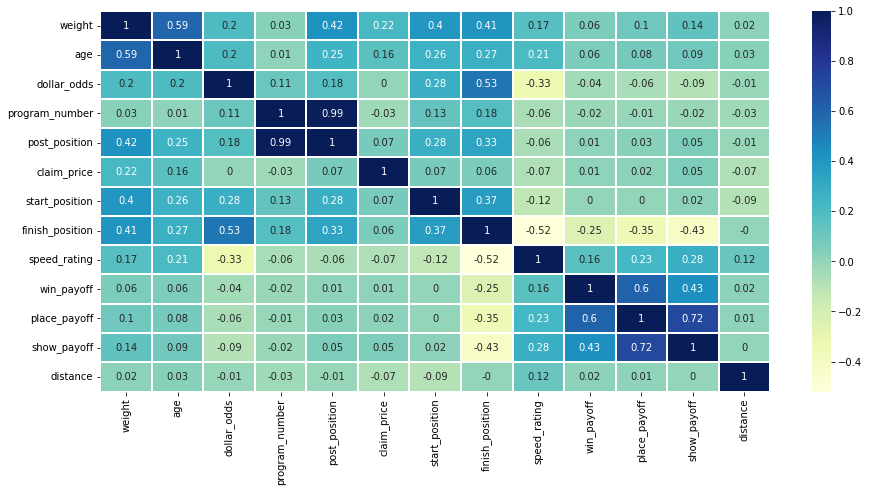

In [182]:
heatmap_columns = df.drop(['race_date','track', 'card_id', 'breed', 'finish_time'], axis=1)
matrix = heatmap_columns.corr().round(2)
f, ax = plt.subplots(figsize =(15, 7))
sns.heatmap(matrix, annot=True,linewidths = 0.1,cmap ="YlGnBu")
plt.show()

#Lets see the correlation between features in our dataset

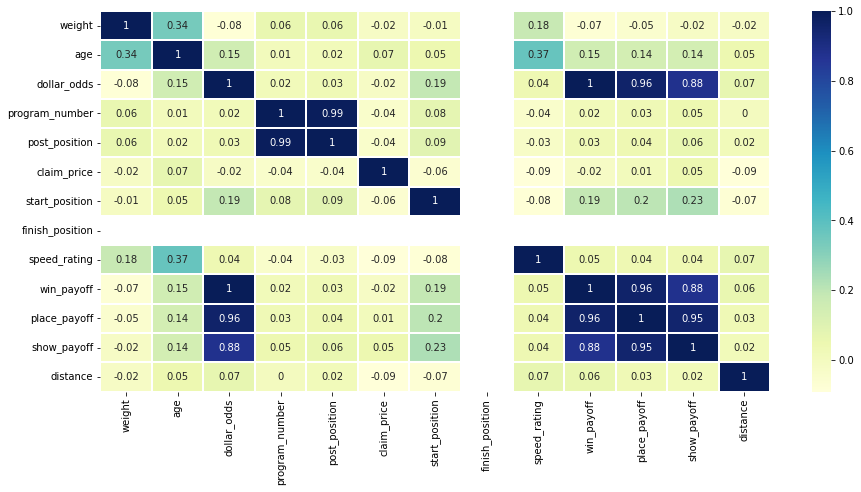

In [183]:
heatmap_columns2 = df.drop(['race_date','track', 'card_id', 'breed', 'finish_time'], axis=1)
heatmap_columns2 = heatmap_columns[heatmap_columns.apply(lambda x: x["finish_position"] == 1, axis=1)]
matrix = heatmap_columns2.corr().round(2)
f, ax = plt.subplots(figsize =(15, 7))
sns.heatmap(matrix, annot=True,linewidths = 0.1,cmap ="YlGnBu")
plt.show()

#Lets see the correlation between features in our dataset, only for the winners, or finish position 1

3234.5166666666664

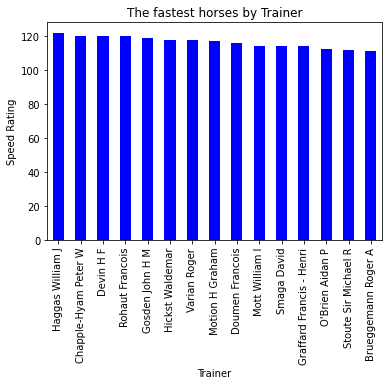

In [184]:
fig, ax = plt.subplots()
df.sort_values('speed_rating')
df.groupby('trainer').mean()['speed_rating'].sort_values(ascending=False).head(15).plot(kind = 'bar', ax = ax, color = 'blue')
plt.title('The fastest horses by Trainer')
plt.xlabel('Trainer') 
plt.ylabel('Speed Rating')

df.groupby('trainer').mean()['speed_rating'].sort_values(ascending=False).head(30).sum()

749.9143600431051

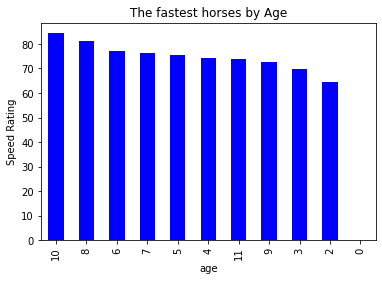

In [185]:
fig, ax = plt.subplots()
df.sort_values('speed_rating')
df.groupby('age').mean()['speed_rating'].sort_values(ascending=False).head(15).plot(kind = 'bar', ax = ax, color = 'blue')
plt.title('The fastest horses by Age')
plt.xlabel('age') 
plt.ylabel('Speed Rating')

df.groupby('age').mean()['speed_rating'].sort_values(ascending=False).head(15).sum()

#It looks like horses more experience are faster, and the preferable range of ages are from 7 to 10 year, when horses start to decrease performance

909.0339789969942

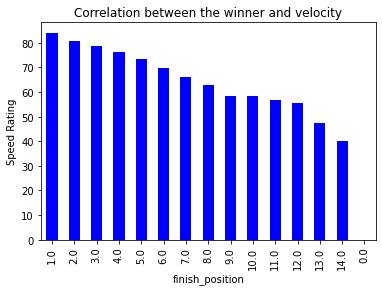

In [186]:
fig, ax = plt.subplots()
df.sort_values('speed_rating')
df.groupby('finish_position').mean()['speed_rating'].sort_values(ascending=False).head(15).plot(kind = 'bar', ax = ax, color = 'blue')
plt.title('Correlation between the winner and velocity')
plt.xlabel('finish_position') 
plt.ylabel('Speed Rating')

df.groupby('finish_position').mean()['speed_rating'].sort_values(ascending=False).head(15).sum()

# As we can see, the fastest horse is always the winner.

1120.7705220738842

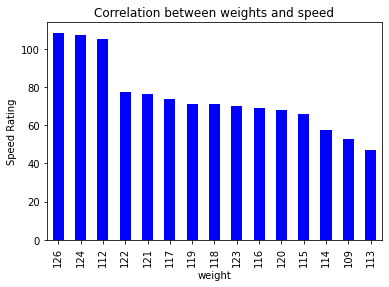

In [187]:
fig, ax = plt.subplots()
df.sort_values('speed_rating')
df.groupby('weight').mean()['speed_rating'].sort_values(ascending=False).head(15).plot(kind = 'bar', ax = ax, color = 'blue')
plt.title('Correlation between weights and speed')
plt.xlabel('weight') 
plt.ylabel('Speed Rating')

df.groupby('weight').mean()['speed_rating'].sort_values(ascending=False).head(15).sum()

#It looks like the weight is really important for the wiinner, as the weightest horses are also the fastest ones, whith some small exceptions.

### Data Cleaning

In [188]:
#First step is to remove all unnecessary columns with no information
df = df.drop(['track', 'card_id', 'breed', 'finish_time'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4370 entries, 0 to 4369
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   race_date         4370 non-null   object 
 1   name              4370 non-null   object 
 2   weight            4370 non-null   int64  
 3   age               4370 non-null   int64  
 4   sex               4053 non-null   object 
 5   meds_and_equip    3907 non-null   object 
 6   jockey            4053 non-null   object 
 7   dollar_odds       4370 non-null   float64
 8   program_number    4053 non-null   float64
 9   post_position     4370 non-null   int64  
 10  claim_price       4370 non-null   int64  
 11  start_position    4370 non-null   float64
 12  finish_position   4370 non-null   float64
 13  speed_rating      4053 non-null   float64
 14  trainer           4053 non-null   object 
 15  owner             4053 non-null   object 
 16  win_payoff        4370 non-null   float64


In [189]:
# Upon review there are numerous records with missing values, these records only include basic information like the horses name
# making them unsuitable for our model
df.dropna(subset = ["trainer"], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4053 entries, 0 to 4369
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   race_date         4053 non-null   object 
 1   name              4053 non-null   object 
 2   weight            4053 non-null   int64  
 3   age               4053 non-null   int64  
 4   sex               4053 non-null   object 
 5   meds_and_equip    3907 non-null   object 
 6   jockey            4053 non-null   object 
 7   dollar_odds       4053 non-null   float64
 8   program_number    4053 non-null   float64
 9   post_position     4053 non-null   int64  
 10  claim_price       4053 non-null   int64  
 11  start_position    4053 non-null   float64
 12  finish_position   4053 non-null   float64
 13  speed_rating      4053 non-null   float64
 14  trainer           4053 non-null   object 
 15  owner             4053 non-null   object 
 16  win_payoff        4053 non-null   float64


In [190]:
# The meds and equipment feature is missing some values.  Looked up what this code means from woodbine's horse program,
# and 'L' represents no equipment.  Changed all Nulls to L'''
df['meds_and_equip'].fillna(value='L')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4053 entries, 0 to 4369
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   race_date         4053 non-null   object 
 1   name              4053 non-null   object 
 2   weight            4053 non-null   int64  
 3   age               4053 non-null   int64  
 4   sex               4053 non-null   object 
 5   meds_and_equip    3907 non-null   object 
 6   jockey            4053 non-null   object 
 7   dollar_odds       4053 non-null   float64
 8   program_number    4053 non-null   float64
 9   post_position     4053 non-null   int64  
 10  claim_price       4053 non-null   int64  
 11  start_position    4053 non-null   float64
 12  finish_position   4053 non-null   float64
 13  speed_rating      4053 non-null   float64
 14  trainer           4053 non-null   object 
 15  owner             4053 non-null   object 
 16  win_payoff        4053 non-null   float64


In [191]:
#Created my features and label
Y = df[['finish_position']]
X = df.drop(['finish_position'], axis=1)
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4053 entries, 0 to 4369
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   race_date         4053 non-null   object 
 1   name              4053 non-null   object 
 2   weight            4053 non-null   int64  
 3   age               4053 non-null   int64  
 4   sex               4053 non-null   object 
 5   meds_and_equip    3907 non-null   object 
 6   jockey            4053 non-null   object 
 7   dollar_odds       4053 non-null   float64
 8   program_number    4053 non-null   float64
 9   post_position     4053 non-null   int64  
 10  claim_price       4053 non-null   int64  
 11  start_position    4053 non-null   float64
 12  speed_rating      4053 non-null   float64
 13  trainer           4053 non-null   object 
 14  owner             4053 non-null   object 
 15  win_payoff        4053 non-null   float64
 16  place_payoff      4053 non-null   float64


In [192]:
#One hot encoded all categorical features 

encoder = LabelEncoder()
encoder.fit(X['race_date'])
X['race_date'] = encoder.transform(X['race_date'])

#Creating dummies for categorical names
X_dummies = pd.get_dummies(X[['name']])
X = pd.concat([X,X_dummies], axis=1)
X.drop('name', axis=1, inplace=True)

#Creating dummies for categorical sex
X_dummies = pd.get_dummies(X[['sex']])
X = pd.concat([X,X_dummies], axis=1)
X.drop('sex', axis=1, inplace=True)

#Creating dummies for meds and equipment
X_dummies = pd.get_dummies(X[['meds_and_equip']])
X = pd.concat([X,X_dummies], axis=1)
X.drop('meds_and_equip', axis=1, inplace=True)

#Creating dummies for jockey
X_dummies = pd.get_dummies(X[['jockey']])
X = pd.concat([X,X_dummies], axis=1)
X.drop('jockey', axis=1, inplace=True)

#Creating dummies for trainer
X_dummies = pd.get_dummies(X[['trainer']])
X = pd.concat([X,X_dummies], axis=1)
X.drop('trainer', axis=1, inplace=True)

#Creating dummies for owner
X_dummies = pd.get_dummies(X[['owner']])
X = pd.concat([X,X_dummies], axis=1)
X.drop('owner', axis=1, inplace=True)

#Creating dummies for weather
X_dummies = pd.get_dummies(X[['weather']])
X = pd.concat([X,X_dummies], axis=1)
X.drop('weather', axis=1, inplace=True)

#Creating dummies for race type
X_dummies = pd.get_dummies(X[['race_type']])
X = pd.concat([X,X_dummies], axis=1)
X.drop('race_type', axis=1, inplace=True)

#Creating dummies for track conditions
X_dummies = pd.get_dummies(X[['track_conditions']])
X = pd.concat([X,X_dummies], axis=1)
X.drop('track_conditions', axis=1, inplace=True)

X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4053 entries, 0 to 4369
Columns: 2855 entries, race_date to track_conditions_YL
dtypes: float64(8), int32(1), int64(4), uint8(2842)
memory usage: 11.4 MB


In [193]:
#Merged all the non-winning horses to a single category, we will only be predicting first place
Y['finish_position'] = np.where(Y['finish_position'] > 1, 2, Y['finish_position'])
Y = Y.astype(str)
Y_dummies = pd.get_dummies(Y[['finish_position']])
Y = pd.concat([Y,Y_dummies], axis=1)
Y.drop('finish_position', axis=1, inplace=True)
Y.head()

C:\Users\Mike\AppData\Local\Temp/ipykernel_2596/263452758.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y['finish_position'] = np.where(Y['finish_position'] > 1, 2, Y['finish_position'])


,finish_position_1.0,finish_position_2.0
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1


In [194]:
#The next step is to standardize our data (changing the values to between 0 and 1)
from sklearn.preprocessing import StandardScaler
min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(X)

In [195]:
train_x, test_x, train_y, test_y = model_selection.train_test_split(X,Y,test_size = 0.2, random_state = 0)

In [231]:
model = keras.Sequential(
    [
        layers.Dense(5000, activation='sigmoid', name='layer1'),
        layers.Dropout(0.2),        
        layers.Dense(1000, activation='relu', name='layer2'),
        layers.Dense(200, activation='relu', name='layer3'),
        layers.Dense(40, activation='relu', name='layer4'),
        layers.Dense(2, activation='softmax', name='output1'),
    ]
)

In [235]:
model.compile(loss = 'categorical_crossentropy' , optimizer = 'adam' , metrics = ['accuracy'] )

In [236]:
#model.summary() # model architecture
checkpointer = ModelCheckpoint(filepath="weights.hdf5", monitor = 'val_accuracy', verbose=1, save_best_only=True) # save model's best weights

history = model.fit(
                    train_x, 
                    train_y, 
                    epochs=200,  
                    callbacks = [checkpointer], 
                    validation_data = (test_x, test_y)
                    )

model_name = "horserace.h5"
model.save(model_name)

Epoch 1/200
102/102 [==============================] - 1s 9ms/step - loss: 0.5409 - accuracy: 0.8621 - val_loss: 0.5342 - val_accuracy: 0.8792

Epoch 00001: val_accuracy improved from -inf to 0.87916, saving model to weights.hdf5
Epoch 2/200
102/102 [==============================] - 1s 7ms/step - loss: 0.2798 - accuracy: 0.8942 - val_loss: 0.3362 - val_accuracy: 0.8816

Epoch 00002: val_accuracy improved from 0.87916 to 0.88163, saving model to weights.hdf5
Epoch 3/200
102/102 [==============================] - 1s 6ms/step - loss: 0.1844 - accuracy: 0.9198 - val_loss: 0.3577 - val_accuracy: 0.8866

Epoch 00003: val_accuracy improved from 0.88163 to 0.88656, saving model to weights.hdf5
Epoch 4/200
102/102 [==============================] - 1s 6ms/step - loss: 0.1854 - accuracy: 0.9198 - val_loss: 0.4862 - val_accuracy: 0.8866

Epoch 00004: val_accuracy did not improve from 0.88656
Epoch 5/200
102/102 [==============================] - 1s 6ms/step - loss: 0.1381 - accuracy: 0.9392 - va

In [237]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Dense)               (None, 5000)              14280000  
_________________________________________________________________
dropout_16 (Dropout)         (None, 5000)              0         
_________________________________________________________________
layer2 (Dense)               (None, 1000)              5001000   
_________________________________________________________________
layer3 (Dense)               (None, 200)               200200    
_________________________________________________________________
layer4 (Dense)               (None, 40)                8040      
_________________________________________________________________
output1 (Dense)              (None, 2)                 82        
Total params: 19,489,322
Trainable params: 19,489,322
Non-trainable params: 0
_________________________________________

In [238]:
# %% Predictions

y_pred = model.predict(test_x)



In [239]:
#cm = confusion_matrix(y_pred, test_y)


In [240]:
print("\nHistory Keys:\n")
print(history.history.keys())



History Keys:

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


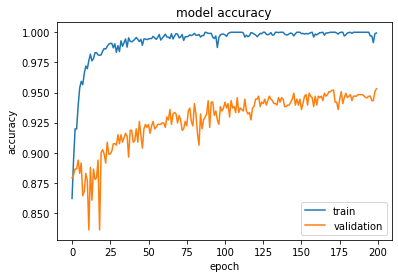

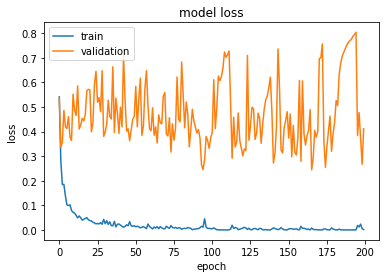

In [241]:
plt.subplots() # open a new plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

plt.subplots() # open a new plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

We tried different hyperparameters to try and increase our accuracy, this is a list of all the hyperparamenters we tuned:
    
    - changing the optimizer
    - changing adding and removing dropouts
    - changing our dense layer number
    - changing our activation functions
    - changing our final layer between softmax and sigmoid
    - changing the kernel

In [242]:
#Here are some interesting models we tried for comparison, this one attempted to change the optimizer

model2 = keras.Sequential(
    [
        layers.Dense(1400, activation='sigmoid', name='layer1'),
        layers.Dense(700, activation='relu', name='layer2'),
        layers.Dense(200, activation='relu', name='layer3'),
        layers.Dense(20, activation='relu', name='layer4'),
        layers.Dense(2, activation='softmax', name='output1'),
    ]
)

optimizer2 = tf.keras.optimizers.Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=True, name="Adam")
model2.compile(loss = 'categorical_crossentropy' , optimizer = optimizer2 , metrics = ['accuracy'] )

#model.summary() # model architecture
checkpointer = ModelCheckpoint(filepath="weightsv2.hdf5", monitor = 'val_accuracy', verbose=1, save_best_only=True) # save model's best weights

history = model2.fit(
                    train_x, 
                    train_y, 
                    epochs=200,  
                    callbacks = [checkpointer], 
                    validation_data = (test_x, test_y)
                    )

model_name = "horseracev2.h5"
model.save(model_name)

Epoch 1/200
102/102 [==============================] - 1s 8ms/step - loss: 0.3605 - accuracy: 0.8871 - val_loss: 0.3717 - val_accuracy: 0.8792

Epoch 00001: val_accuracy improved from -inf to 0.87916, saving model to weightsv2.hdf5
Epoch 2/200
102/102 [==============================] - 0s 5ms/step - loss: 0.3530 - accuracy: 0.8871 - val_loss: 0.3672 - val_accuracy: 0.8792

Epoch 00002: val_accuracy did not improve from 0.87916
Epoch 3/200
102/102 [==============================] - 0s 5ms/step - loss: 0.3509 - accuracy: 0.8871 - val_loss: 0.3690 - val_accuracy: 0.8792

Epoch 00003: val_accuracy did not improve from 0.87916
Epoch 4/200
102/102 [==============================] - 0s 5ms/step - loss: 0.3521 - accuracy: 0.8871 - val_loss: 0.3659 - val_accuracy: 0.8792

Epoch 00004: val_accuracy did not improve from 0.87916
Epoch 5/200
102/102 [==============================] - 0s 5ms/step - loss: 0.3495 - accuracy: 0.8871 - val_loss: 0.3652 - val_accuracy: 0.8792

Epoch 00005: val_accuracy d

In [243]:
y_pred2 = model2.predict(test_x)

In [244]:
print("\nHistory Keys:\n")
print(history.history.keys())


History Keys:

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [245]:
model2.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Dense)               (None, 1400)              3998400   
_________________________________________________________________
layer2 (Dense)               (None, 700)               980700    
_________________________________________________________________
layer3 (Dense)               (None, 200)               140200    
_________________________________________________________________
layer4 (Dense)               (None, 20)                4020      
_________________________________________________________________
output1 (Dense)              (None, 2)                 42        
Total params: 5,123,362
Trainable params: 5,123,362
Non-trainable params: 0
_________________________________________________________________


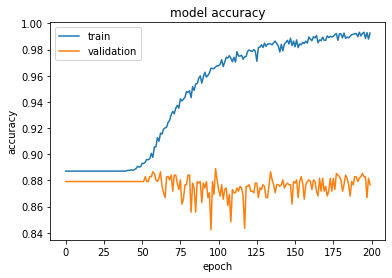

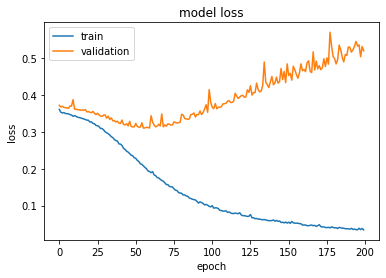

In [246]:
plt.subplots() # open a new plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

plt.subplots() # open a new plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

#As we can see, increase the number of epochs to 150 produces in improvement in accuracy, with some overfitting

In [247]:
#Variation 3, this model attempted to increase dropouts.  As you can see, too many dropout layers hampered our model's learning

model3 = keras.Sequential(
    [
        layers.Dense(1400, activation='sigmoid', name='layer1'),
        layers.Dropout(0.2),
        layers.Dense(700, activation='relu', name='layer2'),
        layers.Dropout(0.2),
        layers.Dense(200, activation='relu', name='layer3'),
        layers.Dropout(0.2),
        layers.Dense(20, activation='relu', name='layer4'),
        layers.Dropout(0.2),
        layers.Dense(2, activation='softmax', name='output1'),
    ]
)

optimizer3 = tf.keras.optimizers.Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=True, name="Adam")
model3.compile(loss = 'categorical_crossentropy' , optimizer = optimizer3 , metrics = ['accuracy'] )

#model.summary() # model architecture
checkpointer = ModelCheckpoint(filepath="weightsv2.hdf5", monitor = 'val_accuracy', verbose=1, save_best_only=True) # save model's best weights

history = model3.fit(
                    train_x, 
                    train_y, 
                    epochs=200,  
                    callbacks = [checkpointer], 
                    validation_data = (test_x, test_y)
                    )

model_name = "horseracev3.h5"
model.save(model_name)

Epoch 1/200
102/102 [==============================] - 1s 9ms/step - loss: 0.3809 - accuracy: 0.8862 - val_loss: 0.3696 - val_accuracy: 0.8792

Epoch 00001: val_accuracy improved from -inf to 0.87916, saving model to weightsv2.hdf5
Epoch 2/200
102/102 [==============================] - 1s 5ms/step - loss: 0.3735 - accuracy: 0.8871 - val_loss: 0.3683 - val_accuracy: 0.8792

Epoch 00002: val_accuracy did not improve from 0.87916
Epoch 3/200
102/102 [==============================] - 1s 5ms/step - loss: 0.3721 - accuracy: 0.8871 - val_loss: 0.3706 - val_accuracy: 0.8792

Epoch 00003: val_accuracy did not improve from 0.87916
Epoch 4/200
102/102 [==============================] - 1s 5ms/step - loss: 0.3766 - accuracy: 0.8871 - val_loss: 0.3690 - val_accuracy: 0.8792

Epoch 00004: val_accuracy did not improve from 0.87916
Epoch 5/200
102/102 [==============================] - 1s 5ms/step - loss: 0.3717 - accuracy: 0.8871 - val_loss: 0.3682 - val_accuracy: 0.8792

Epoch 00005: val_accuracy d

In [248]:
y_pred2 = model3.predict(test_x)

In [249]:
print("\nHistory Keys:\n")
print(history.history.keys())


History Keys:

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [250]:
model3.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Dense)               (None, 1400)              3998400   
_________________________________________________________________
dropout_17 (Dropout)         (None, 1400)              0         
_________________________________________________________________
layer2 (Dense)               (None, 700)               980700    
_________________________________________________________________
dropout_18 (Dropout)         (None, 700)               0         
_________________________________________________________________
layer3 (Dense)               (None, 200)               140200    
_________________________________________________________________
dropout_19 (Dropout)         (None, 200)               0         
_________________________________________________________________
layer4 (Dense)               (None, 20)              

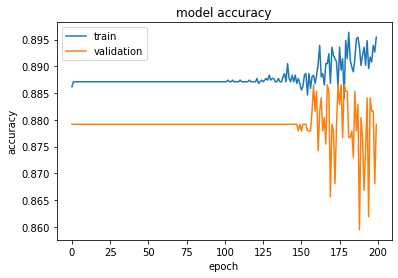

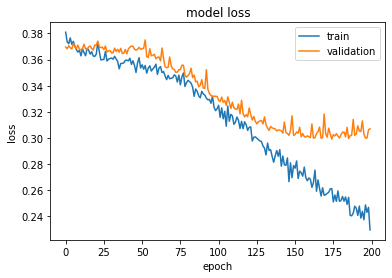

In [251]:
plt.subplots() # open a new plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

plt.subplots() # open a new plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

#As we see overfitting in the previous model, we tried to increase even more our number of epochs to 200, and also we tried to add Dropouts to avoid a possible overfitting
# for this trial, the accuracyhas dropped slighly

In [256]:
#In this attempt we tried a kernel regularization of l2, the results were comparable to our final model and this is definitely an option
#for our final model

model4 = keras.Sequential(
    [
        layers.Dense(2000, activation='sigmoid', name='layer1', kernel_regularizer='l2'), #addin kernel regularizer to try to decrease overfitting
        tf.keras.layers.BatchNormalization(), # this is batch normalization, another technique for improve overfiting training sets
        layers.Dropout(0.2),
        layers.Dense(1000, activation='relu', name='layer2', kernel_regularizer='l2',kernel_initializer='he_uniform'),
        tf.keras.layers.BatchNormalization(),
        layers.Dense(300, activation='relu', name='layer3', kernel_regularizer='l2'),
        tf.keras.layers.BatchNormalization(),
        layers.Dense(50, activation='relu', name='layer4', kernel_regularizer='l2'),
        tf.keras.layers.BatchNormalization(),     
        layers.Dense(2, activation='softmax', name='output1', kernel_regularizer='l2'),
    ]
)

model4.compile(loss = 'categorical_crossentropy' , optimizer = 'adam' , metrics = ['accuracy'] )

#model.summary() # model architecture
checkpointer = ModelCheckpoint(filepath="weightsv4.hdf5", monitor = 'val_accuracy', verbose=1, save_best_only=True) # save model's best weights

history = model4.fit(
                    train_x, 
                    train_y, 
                    epochs=200,  
                    callbacks = [checkpointer], 
                    validation_data = (test_x, test_y), verbose=2
                    )

model_name = "horseracev4.h5"
model.save(model_name)

Epoch 1/200
102/102 - 2s - loss: 20.3339 - accuracy: 0.7239 - val_loss: 7.4991 - val_accuracy: 0.8792

Epoch 00001: val_accuracy improved from -inf to 0.87916, saving model to weightsv4.hdf5
Epoch 2/200
102/102 - 1s - loss: 3.8839 - accuracy: 0.8714 - val_loss: 1.9510 - val_accuracy: 0.8792

Epoch 00002: val_accuracy did not improve from 0.87916
Epoch 3/200
102/102 - 1s - loss: 1.3025 - accuracy: 0.8751 - val_loss: 1.0538 - val_accuracy: 0.8792

Epoch 00003: val_accuracy did not improve from 0.87916
Epoch 4/200
102/102 - 1s - loss: 0.8273 - accuracy: 0.8846 - val_loss: 0.8571 - val_accuracy: 0.8792

Epoch 00004: val_accuracy did not improve from 0.87916
Epoch 5/200
102/102 - 1s - loss: 0.6684 - accuracy: 0.8917 - val_loss: 0.7397 - val_accuracy: 0.8792

Epoch 00005: val_accuracy did not improve from 0.87916
Epoch 6/200
102/102 - 1s - loss: 0.5902 - accuracy: 0.8961 - val_loss: 0.6735 - val_accuracy: 0.8792

Epoch 00006: val_accuracy did not improve from 0.87916
Epoch 7/200
102/102 - 1s

In [257]:
y_pred4 = model4.predict(test_x)

In [258]:
print("\nHistory Keys:\n")
print(history.history.keys())


History Keys:

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [259]:
model4.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Dense)               (None, 2000)              5712000   
_________________________________________________________________
batch_normalization_12 (Batc (None, 2000)              8000      
_________________________________________________________________
dropout_24 (Dropout)         (None, 2000)              0         
_________________________________________________________________
layer2 (Dense)               (None, 1000)              2001000   
_________________________________________________________________
batch_normalization_13 (Batc (None, 1000)              4000      
_________________________________________________________________
layer3 (Dense)               (None, 300)               300300    
_________________________________________________________________
batch_normalization_14 (Batc (None, 300)             

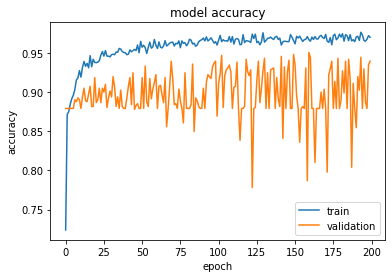

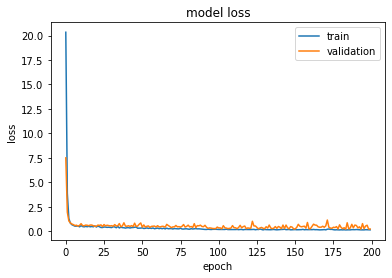

In [260]:
plt.subplots() # open a new plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

plt.subplots() # open a new plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

#As we didn't see overfitting in the previous model, we tried to increase even more our number of epochs to 200, and also we tried to add Dropouts to avoid a possible overfitting
# for this trial, the validation accuracyhas dropped slighly after 50 epochs, so we kept the model at 50 epochs, with Ridge Regularization, batch normalization and 4 layers

### Comparison to Traditional ML Models

In [261]:
import pandas as pd
import numpy as np
import glob
import os
import re
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing, model_selection
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn import metrics
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

In [262]:
# Training test split for machine learning algorithm
train_X, test_X, train_Y, test_Y = model_selection.train_test_split(X,Y,test_size = 0.2, random_state = 1)

In [263]:
# Decision Tree Classifier
from sklearn import tree

model1 = tree.DecisionTreeClassifier()
model1.fit(train_X, train_Y)
y_pred = model1.predict(test_X)
cm2 = confusion_matrix(y_pred, test_Y)
total2=sum(sum(cm2))
Accuracy = (cm2[0,0]+cm2[1,1])/total2
Specificity = cm2[0,0]/(cm2[0,0]+cm2[0,1])
Sensitivity = cm2[1,1]/(cm2[1,0]+cm2[1,1])
print("Accuracy of  Decision Tree:", Accuracy, "--Sensitivity of Decision Tree :", Sensitivity, "--Specificity of  Decision Tree:", Specificity )

ValueError: multilabel-indicator is not supported

In [264]:
#SVM Classifier
model4 = SVC(kernel='rbf', random_state = 1)
model4.fit(train_X, train_Y)
y_pred = model4.predict(test_X)
cm4 = confusion_matrix(y_pred, test_Y)
total4=sum(sum(cm4))
Accuracy = (cm4[0,0]+cm4[1,1])/total4
Specificity = cm4[0,0]/(cm4[0,0]+cm4[0,1])
Sensitivity = cm4[1,1]/(cm4[1,0]+cm4[1,1])
print("Accuracy of  SVM :", Accuracy, "--Sensitivity of  SVM :", Sensitivity, "--Specificity of  SVM :", Specificity )


ValueError: y should be a 1d array, got an array of shape (3242, 2) instead.

In [265]:
#  GaussianNB 
model5 = GaussianNB()
model5.fit(train_X, train_Y)
y_pred = model5.predict(test_X)
cm5 = confusion_matrix(y_pred, test_Y)
total5=sum(sum(cm5))
Accuracy = (cm5[0,0]+cm5[1,1])/total5
    
Specificity = cm5[0,0]/(cm5[0,0]+cm5[0,1])
Sensitivity = cm5[1,1]/(cm5[1,0]+cm5[1,1])
print("Accuracy of  GaussianNB :", Accuracy, "--Sensitivity of  GaussianNB :", Sensitivity, "--Specificity of  GaussianNB :", Specificity )


ValueError: y should be a 1d array, got an array of shape (3242, 2) instead.

In [267]:
model6 = KNeighborsClassifier(n_neighbors=3)

model6.fit(train_X, train_Y)
 
# making predictions on the testing set
y_pred = model6.predict(test_X)
cm6 = confusion_matrix(y_pred, test_Y)
total6=sum(sum(cm6))
Accuracy = (cm6[0,0]+cm6[1,1])/total6
Specificity= cm6[0,0]/(cm6[0,0]+cm6[0,1])
Sensitivity = cm6[1,1]/(cm6[1,0]+cm6[1,1])
print("Accuracy of KNN:", Accuracy, "--Sensitivity of KNN:", Sensitivity, "--Specificity of KNN:", Specificity )

ValueError: multilabel-indicator is not supported